<h1> Robot Navigation Project </h1>

In [171]:
## referencies:
# http://vision.deis.unibo.it/~smatt/Papers/VI2002/VI2002.pdf

<h3> Libraries and Global Variables </h3>

In [1]:
f = 567.2 # focal length in pixel
b = 92.226 # base line in mm
cb_w = 125 # chessboard total width in  mm
cb_h = 178 # chessboard total height in mm
pattern_size = (6, 8) # number of inner corner, (columns, rows) of chessboard

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba
from joblib import Parallel, delayed
import cProfile
import pstats
from multiprocessing import Pool
import cython

<h3> Extracting image frames from video </h3>

In [3]:
roboL = cv2.VideoCapture('./robotL.avi')
roboL_frames = []

while roboL.isOpened():
    ret, frame = roboL.read()
    if not ret:
        break
    roboL_frames = roboL_frames + [frame]

In [4]:
roboR = cv2.VideoCapture('./robotR.avi')
roboR_frames = []

while roboR.isOpened():
    ret, frame = roboR.read()
    if not ret:
        break
    roboR_frames = roboR_frames + [frame]

In [5]:
print("No. of frames for left camera : ", len(roboL_frames))
print("No of frames for right camera : ", len(roboR_frames))

No. of frames for left camera :  389
No of frames for right camera :  389


In [6]:
if len(roboL_frames) != len(roboR_frames):
    print('Error number of frames dos not match')
number_of_frames = len(roboL_frames)
print(number_of_frames)

389


In [7]:
roboL_frames[10].shape

(480, 640, 3)

<h3> Image Processing & Histogram Analysis on single image </h3>

In [8]:
img = roboL_frames[100]

In [9]:
def plot_histogram(image, title, mask=None):
	# split the image into its respective channels, then initialize
	# the tuple of channel names along with our figure for plotting
	chans = cv2.split(image)
	colors = ("b", "g", "r")
	plt.figure()
	plt.title(title)
	plt.xlabel("Bins")
	plt.ylabel("# of Pixels")
	# loop over the image channels
	for (chan, color) in zip(chans, colors):
		# create a histogram for the current channel and plot it
		hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
		plt.plot(hist, color=color)
		plt.xlim([0, 256])

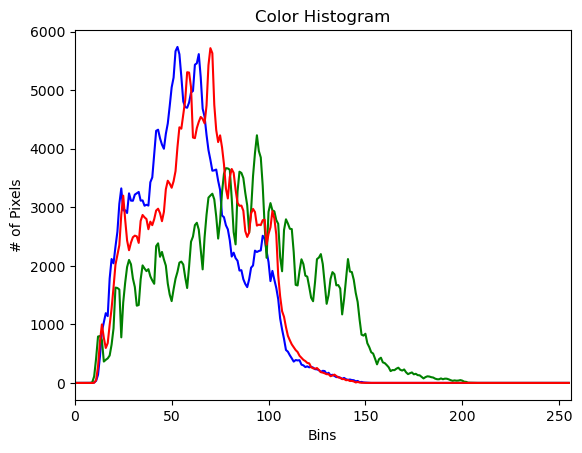

In [10]:
plot_histogram(img, 'Color Histogram')

In [11]:
img_gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

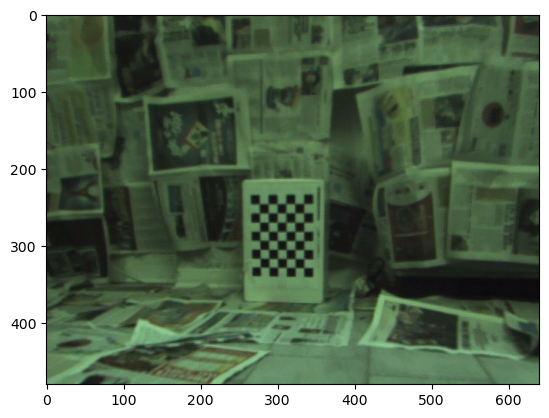

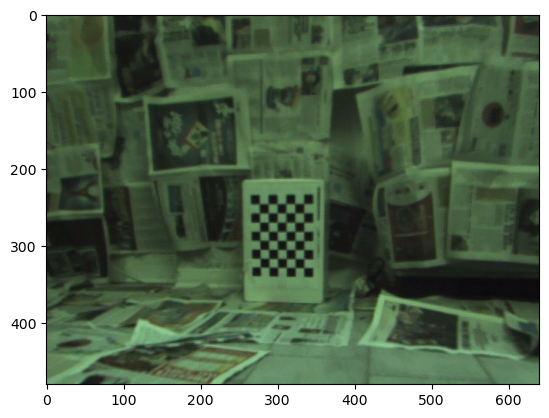

In [12]:
img_x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_x)
plt.show()
img_x = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_x)
plt.show()

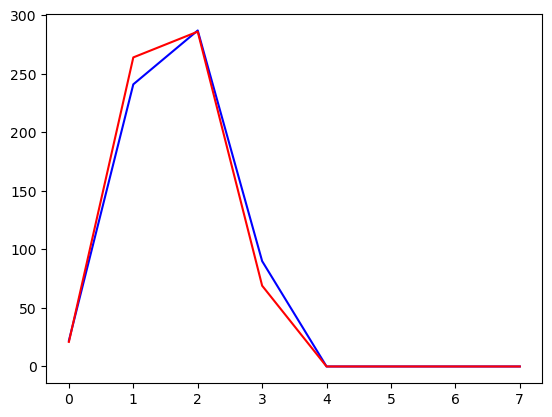

In [13]:
hist1 = cv2.calcHist(img_gray1, [0], None, [8], [0, 256])
hist2 = cv2.calcHist(img_gray2, [0], None, [8], [0, 256])
plt.plot(hist1, 'b')
plt.plot(hist2, 'r')
plt.show()

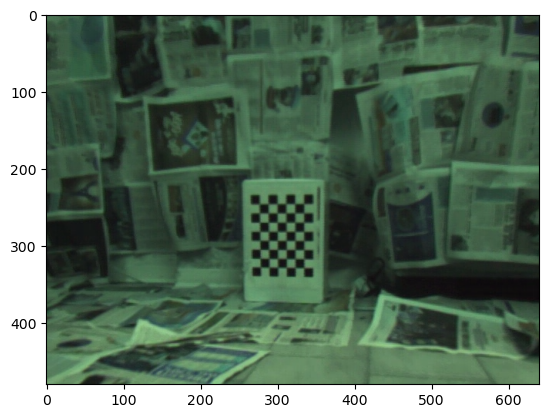

In [14]:
plt.imshow(img)
plt.show()

<h3> Converting to NumPy Array </h3>


In [15]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)

<h2> Cropping </h2>

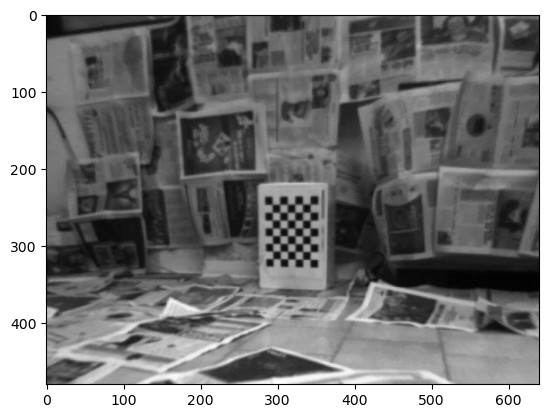

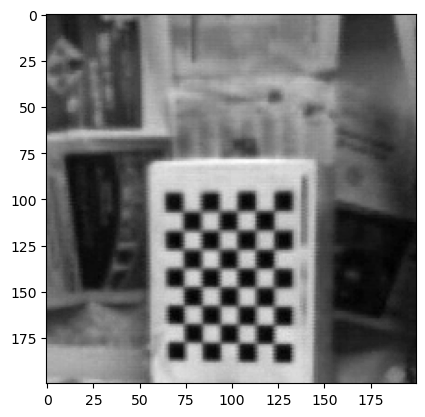

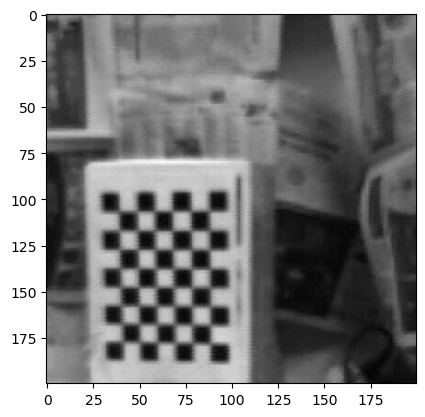

uint8
uint8


(389, 480, 640)

In [16]:
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_R])
framenumber = 200 #310

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side-offset:int(Frame_width/2)+sq_area_side-offset]

# Display the images
plt.imshow(np_L_gray[framenumber], cmap='gray')
plt.show()
# plt.imshow(np_R_gray[framenumber], cmap='gray')
# plt.show()
plt.imshow(np_L_cropped, cmap='gray')
plt.show()
plt.imshow(np_R_cropped, cmap='gray')
plt.show()

print(np_L_cropped.dtype)
print(np_R_cropped.dtype)

np_L_gray.shape

# Disparity map with StereoBM

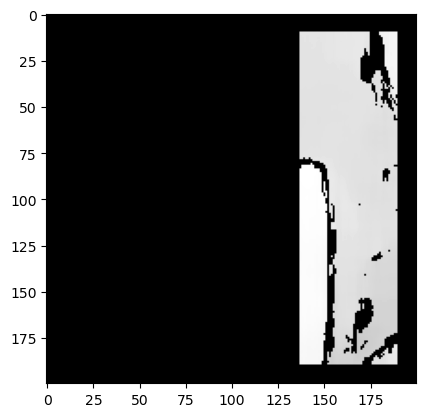

Mean positive disparity: 32.08664840047393


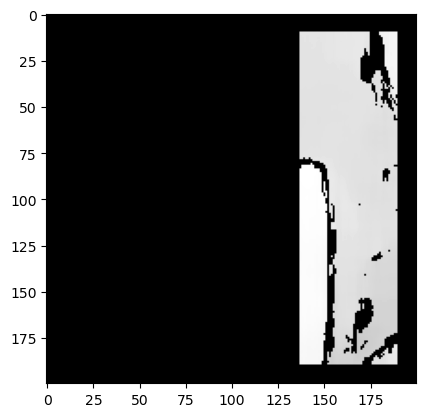

In [17]:
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=21)

disparity = stereo.compute(np_L_cropped,np_R_cropped)
plt.imshow(disparity,'gray')
plt.show()

disparity=disparity/16
plt.imshow(disparity,'gray')

# Filter out positive disparity values
positive_disparities = disparity[disparity >= 0]

# Calculate mean of positive disparities
mean_disparity = np.mean(positive_disparities)

print("Mean positive disparity:", mean_disparity)

# Disparity map with StereoSGBM

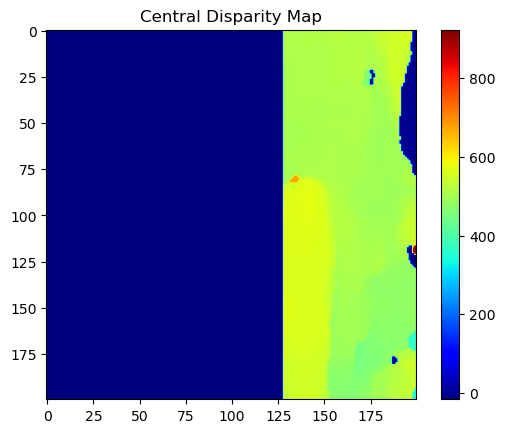

32.230320489737124

In [18]:
minDisparity=0                  # Minimum possible disparity value
numDisparities=128                # Range of disparity (maxDisparity - minDisparity)
block_size= 21                     # Size of the window used for matching (odd values only)
P1=0                              # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0               # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0              # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)
disparity = stereo.compute(np_L_cropped,np_R_cropped)
#disparity_map = cv2.normalize(disparity_map, disparity_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title(f'Central Disparity Map')
plt.show()

disparity=disparity/16
positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)
mean_disparity


<h2> Custom Disparity Function </h2>

In [19]:
@numba.jit
def sad_fn(L_window, R_window):
    return np.sum(np.abs(L_window - R_window))

@numba.jit
def ssd_fn(L_window, R_window):
    return np.sum((L_window - R_window)**2)

@numba.jit
def ncc_fn(L_window, R_window):
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

@numba.jit
def zncc_fn(L_window, R_window):
    L_window = L_window - np.mean(L_window)
    R_window = R_window - np.mean(R_window)
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

def compute_disparity_cost(block_size, L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn):
    if pixel_y-block_size//2 < 0 or L_pixel_x-block_size//2 < 0 or R_pixel_x-block_size//2 < 0:
        return np.inf
    if pixel_y+block_size//2+1 >= L_img.shape[0] or L_pixel_x+block_size//2+1 >= L_img.shape[1] or R_pixel_x+block_size//2+1 >= R_img.shape[1]:
        return np.inf
    L_window = L_img[pixel_y-block_size//2:pixel_y+block_size//2+1, L_pixel_x-block_size//2:L_pixel_x+block_size//2+1]
    R_window = R_img[pixel_y-block_size//2:pixel_y+block_size//2+1, R_pixel_x-block_size//2:R_pixel_x+block_size//2+1]
    cost = cost_fn(L_window, R_window)
    return cost

def compute_disparity_map(L_img, R_img, d_max, blockSize, cost_fn):
    disparity = -1*np.ones_like(L_img)
    img_hight, img_width = L_img.shape
    for i in range(img_hight):
        for j in range(d_max, img_width):
            min_cost = float('inf')
            min_k = 0
            max_cost = 0
            for k in range(j-d_max, j):
                cost = compute_disparity_cost(blockSize, L_img, R_img, i, j, k, cost_fn)
                if (cost_fn == zncc_fn) or (cost_fn == ncc_fn):
                    if max_cost < cost:
                        max_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1
                else:      
                    if min_cost > cost:
                        min_cost = cost
                        min_k = k
                    if cost == float('inf'):
                        min_k = j+1

            disparity[i][j] = j-min_k
    return disparity


In [20]:
# TRING TO IMPROVE PERFORMANCE BY PARALLELIZATION
@numba.njit
def sad_fn(L_window, R_window):
    return np.sum(np.abs(L_window - R_window))

@numba.njit
def ssd_fn(L_window, R_window):
    return np.sum((L_window - R_window)**2)

@numba.njit
def ncc_fn(L_window, R_window):
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

@numba.njit
def zncc_fn(L_window, R_window):
    L_window = L_window - np.mean(L_window)
    R_window = R_window - np.mean(R_window)
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

def compute_disparity_cost(block_size, L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn):
    if pixel_y-block_size//2 < 0 or L_pixel_x-block_size//2 < 0 or R_pixel_x-block_size//2 < 0:
        return np.inf
    if pixel_y+block_size//2+1 >= L_img.shape[0] or L_pixel_x+block_size//2+1 >= L_img.shape[1] or R_pixel_x+block_size//2+1 >= R_img.shape[1]:
        return np.inf
    L_window = L_img[pixel_y-block_size//2:pixel_y+block_size//2+1, L_pixel_x-block_size//2:L_pixel_x+block_size//2+1]
    R_window = R_img[pixel_y-block_size//2:pixel_y+block_size//2+1, R_pixel_x-block_size//2:R_pixel_x+block_size//2+1]
    cost = cost_fn(L_window, R_window)
    return cost

def compute_disparity_map_parallel(L_img, R_img, d_max, blockSize, cost_fn):
    disparity = -1*np.ones_like(L_img)
    img_hight, img_width = L_img.shape

    #@numba.njit
    def compute_disparity_for_pixel(i, j):
        min_cost = np.inf
        min_k = 0
        for k in range(j-d_max, j):
            cost = compute_disparity_cost(blockSize, L_img, R_img, i, j, k, cost_fn)
            if min_cost > cost:
                min_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
        return j-min_k

    results = Parallel(n_jobs=-1)(delayed(compute_disparity_for_pixel)(i, j) for i in range(img_hight) for j in range(d_max, img_width))
    
    for i in range(img_hight):
        for j in range(d_max, img_width):
            disparity[i][j] = results.pop(0)
    return disparity

In [76]:
@numba.njit(fastmath=True)
def sad_fn(L_window, R_window):
    return np.sum(np.abs(L_window - R_window))

@numba.njit(fastmath=True)
def ssd_fn(L_window, R_window):
    return np.sum((L_window - R_window)**2)

@numba.njit(fastmath=True)
def ncc_fn(L_window, R_window):
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

@numba.njit(fastmath=True)
def zncc_fn(L_window, R_window):
    L_window = L_window - np.mean(L_window)
    R_window = R_window - np.mean(R_window)
    return np.sum(L_window * R_window) / (np.sqrt(np.sum(L_window**2)) * np.sqrt(np.sum(R_window**2)))

def compute_disparity_cost(crop_border, L_img, R_img, pixel_y, L_pixel_x, R_pixel_x, cost_fn):
    L_window = L_img[pixel_y-crop_border:pixel_y+crop_border+1, L_pixel_x-crop_border:L_pixel_x+crop_border+1]
    R_window = R_img[pixel_y-crop_border:pixel_y+crop_border+1, R_pixel_x-crop_border:R_pixel_x+crop_border+1]
    return cost_fn(L_window, R_window)

def compute_disparity_for_pixel(i, j, L_img, R_img, d_max, cost_fn, crop_border):
    min_cost = np.inf
    max_cost = -np.inf
    min_k = 0
    for k in range(j-d_max, j):
        cost = compute_disparity_cost(crop_border, L_img, R_img, i, j, k, cost_fn)
        if (cost_fn == zncc_fn) or (cost_fn == ncc_fn):
            if max_cost < cost:
                max_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
        else: 
            if min_cost > cost:
                min_cost = cost
                min_k = k
            if cost == np.inf:
                min_k = j+1
    return j-min_k, cost

def compute_disparity_map_parallel(L_img, R_img, d_max, block_size, cost_fn):
    img_hight, img_width = L_img.shape   
    crop_border = block_size//2    
    hight_range=range(crop_border,img_hight-crop_border)
    width_range=range(d_max+crop_border, img_width-crop_border)

    disparity = -1*np.ones_like(L_img)
    cost_values = np.zeros((img_hight,img_width))    

    with Pool(processes=4) as p:
        results = p.starmap(compute_disparity_for_pixel, [(i, j, L_img, R_img, d_max, cost_fn, crop_border) for i in hight_range for j in width_range])
    
    for idx, result in enumerate(results):
        i = hight_range[idx // len(width_range)]
        j = width_range[idx % len(width_range)]
        disparity[i][j], cost_values[i][j] = result
    return disparity, cost_values


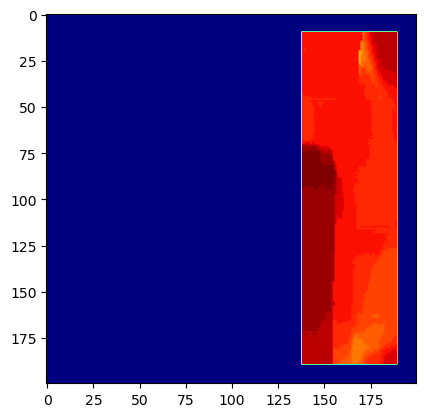

32.17446581196581

In [79]:
d_max = 128
block_size = 21
cost_fn = ssd_fn # sad_fn, ssd_fn, ncc_fn, zncc_fn
#disparity = compute_disparity_map(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)
disparity, cost = compute_disparity_map_parallel(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)

plt.imshow(disparity, cmap = 'jet')
plt.show()

# plt.imshow(cost, cmap = 'jet')
# plt.show()

positive_disparities = disparity[disparity > 0]
mean_disparity = np.mean(positive_disparities)
mean_disparity

In [348]:
with cProfile.Profile() as profile:
        
    d_max = 128
    block_size = 21
    cost_fn = ssd_fn # sad_fn, ssd_fn, ncc_fn, zncc_fn
    disparity = compute_disparity_map(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)
    #disparity, cost = compute_disparity_map_parallel(np_L_cropped, np_R_cropped, d_max, block_size, cost_fn)

    positive_disparities = disparity[disparity > 0]
    mean_disparity = np.mean(positive_disparities)
    mean_disparity  
    
    results = pstats.Stats(profile)
    results.sort_stats(pstats.SortKey.TIME)
    results.print_stats()
    results.dump_stats('profile_results2')



         3442953 function calls (3428526 primitive calls) in 13.406 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1843200    6.768    0.000   10.358    0.000 /tmp/ipykernel_256255/1251441618.py:19(compute_disparity_cost)
        1    3.049    3.049   13.406   13.406 /tmp/ipykernel_256255/1251441618.py:29(compute_disparity_map)
  1387787    2.844    0.000    2.844    0.000 /tmp/ipykernel_256255/1251441618.py:5(ssd_fn)
      837    0.072    0.000    0.142    0.000 /usr/lib/python3.11/site-packages/llvmlite/binding/ffi.py:190(__call__)
    22929    0.032    0.000    0.036    0.000 {built-in method builtins.isinstance}
4987/2522    0.024    0.000    0.074    0.000 /usr/lib/python3.11/pprint.py:554(_safe_repr)
 2647/465    0.021    0.000    0.036    0.000 /usr/lib/python3.11/site-packages/numba/core/ir.py:317(_rec_list_vars)
      421    0.016    0.000    0.044    0.000 {built-in method builtins.sorted}
4987/2522    0.014   

<h3> Detecting Corners Single Image </h3>

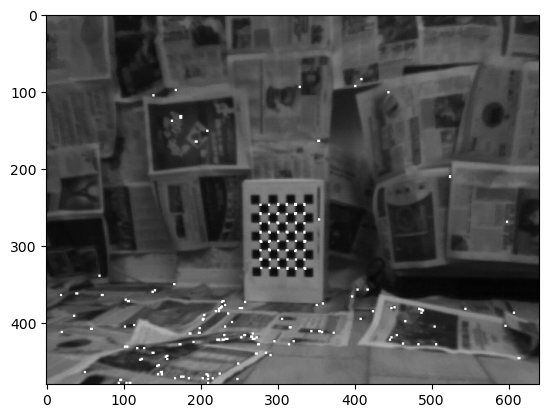

In [142]:
corners = cv2.cornerHarris(img_gray1, 2, 3, 0.2)
#result is dilated for marking the corners, not important
corners = cv2.dilate(corners,None)
# Threshold for an optimal value, it may vary depending on the image.
img_pts1 = img_gray1.copy()
img_pts1[corners>0.01*corners.max()]=[255]
plt.imshow(img_pts1, cmap='gray')
plt.show()

<h3> Matching Corner Points Single Image </h3>

In [143]:
# Format Conversion CornerHarris to use SIFT Descriptor
keypoints = np.argwhere(corners > 0.01 * corners.max())
keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 13) for x in keypoints]

### Compute SIFT Descriptor

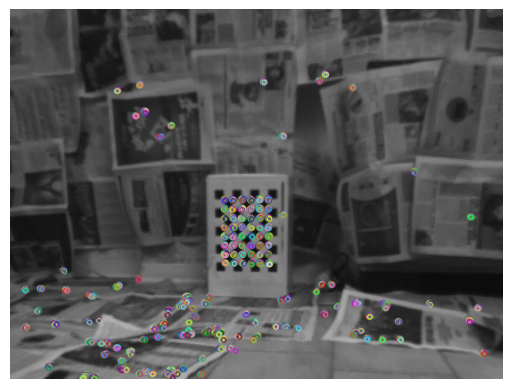

In [144]:
sift = cv2.SIFT_create()
sift.compute(img, keypoints)
img_sift = cv2.drawKeypoints(img_gray1, keypoints, img_gray1)
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axes
plt.show()


<h3> Detecting Chessboard Pattern (Single Image)</h3>

In [145]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
found, corners = cv2.findChessboardCorners(img_gray1, pattern_size)

# Do cornerSubPix only if chessboard found is True
if found:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(img_gray1, corners, (5, 5), (-1, -1), term)
    print("Corner found")
else:
    print("Corner not found")
    
print("Shape of corners: ", corners.shape)

Corner found
Shape of corners:  (48, 1, 2)


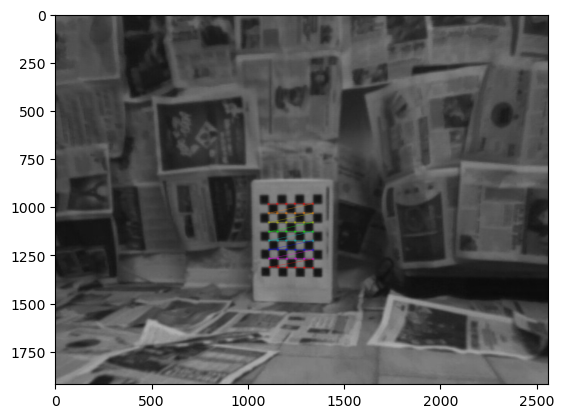

In [146]:
vis = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, corners*4, found)
#plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

# Computing distance of the camera from the chessboard referred to specific frame 

In [147]:
imgL = roboL_frames[100]
imgR = roboR_frames[100]
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

In [148]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
foundL, cornersL = cv2.findChessboardCorners(imgL_gray, pattern_size)
foundR, cornersR = cv2.findChessboardCorners(imgR_gray, pattern_size)

# Do cornerSubPix only if chessboard found is True
if foundL and foundR:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(imgL_gray, cornersL, (5, 5), (-1, -1), term)
    cv2.cornerSubPix(imgR_gray, cornersR, (5, 5), (-1, -1), term)

print("Found: " , foundL)
print("Found: " , foundR)
#print("2D image coordinate of corners: ", cornersL)
#print("2D image coordinate of corners: ", cornersR)

Found:  True
Found:  True


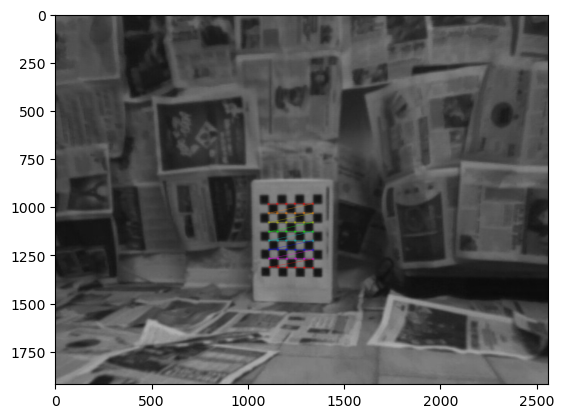

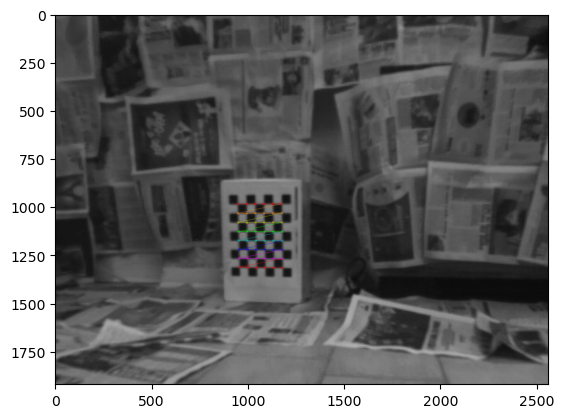

In [149]:
# Draw and display the corners for both images
vis = cv2.cvtColor(imgL_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersL*4, found)
plt.figure()
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

vis = cv2.cvtColor(imgR_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersR*4, found)
plt.figure()
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [150]:
Lxi = [elem[0][0] for elem in cornersL]
Rxi = [elem[0][0] for elem in cornersR]
print('X coordinate of corners in left and right images:')
print(Lxi) 
print(Rxi)

X coordinate of corners in left and right images:
[276.92728, 288.51187, 300.20468, 311.33182, 322.9879, 334.66174, 277.2161, 288.53366, 300.17303, 311.5126, 323.00702, 334.67432, 277.41953, 288.64554, 300.26486, 311.60876, 323.05637, 334.69974, 277.68854, 288.85208, 300.36777, 311.8518, 323.20172, 334.7108, 277.85178, 289.04422, 300.37253, 311.86093, 323.3611, 334.77222, 278.02557, 289.1917, 300.58997, 312.06073, 323.39685, 334.7588, 278.0144, 289.5741, 300.652, 312.15082, 323.4769, 334.87503, 278.38403, 289.63144, 300.92438, 312.0662, 323.55325, 334.88135]
[236.79779, 248.71585, 259.58905, 271.24503, 282.61118, 294.19067, 237.381, 248.77657, 259.80734, 271.37018, 282.68024, 294.3914, 237.6592, 249.02568, 260.1336, 271.6233, 283.15085, 294.48, 238.15526, 249.32541, 260.3098, 271.9568, 283.47504, 294.70114, 238.30907, 249.51314, 260.63638, 272.1152, 283.53473, 294.94266, 238.93463, 249.93488, 261.28827, 272.32593, 283.81818, 295.02402, 239.15953, 250.10374, 261.49365, 272.562, 283.9509

[40.129486, 39.79602, 40.61563, 40.086792, 40.37674, 40.47107, 39.8351, 39.757095, 40.365692, 40.142426, 40.326782, 40.28293, 39.76033, 39.619858, 40.131256, 39.985474, 39.905518, 40.219727, 39.53328, 39.526672, 40.057953, 39.89502, 39.726685, 40.009644, 39.54271, 39.531082, 39.736145, 39.745728, 39.826385, 39.82956, 39.090942, 39.256836, 39.301697, 39.734802, 39.578674, 39.73477, 38.854874, 39.470352, 39.158356, 39.588806, 39.52594, 39.590942, 38.70076, 39.22737, 39.03882, 39.282623, 39.35135, 39.574768]
disparity: 39.7256555557251


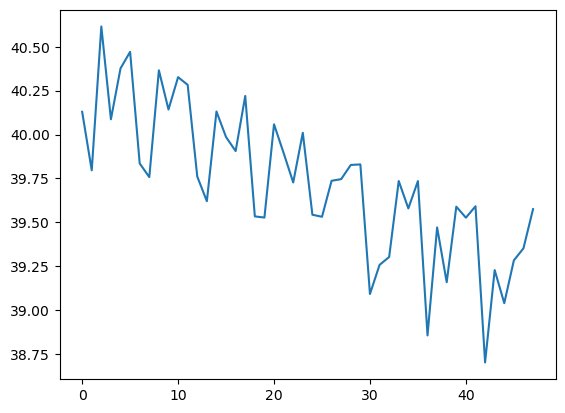

In [151]:
# Calculate disparity
diffs = []
for l, r in zip(Lxi, Rxi):
    diff = l - r
    diffs.append(diff)

d = sum(diffs)/len(diffs)

print(diffs)
print("disparity:", d)

plt.plot(diffs);


In [152]:
z = (b * f)/d 
print("Distance of the obstacle (mm):",z)

Distance of the obstacle (mm): 1316.7960721660443


# Numpy Array for frames

In [153]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_R])

# Computing distances of the camera from the chessboard during the whole video by uing Chessboard corners


In [154]:
# Find chessboard corners in each frame for left camera

pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
list_foundL = []
list_cornersL = []

progress = 0
for frame in np_L_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundL.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersL.append(corners)
    else:
        print("not found", progress, end=', ')
        #list_foundL.append(None)
        list_cornersL.append(None)
    
        

print("job completed")

not found 1, 2, not found 3, 4, not found 5, not found 6, 7, 8, 9, 10, not found 11, not found 12, not found 13, not found 14, not found 15, not found 16, not found 17, 18, 19, 20, 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, 28, 29, 30, 31, 32, not found 33, not found 34, not found 35, not found 36, not found 37, 38, 39, 40, not found 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172

In [155]:
# Find chessboard corners in each frame for right camera

list_foundR = []
list_cornersR = []

progress = 0
for frame in np_R_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundR.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersR.append(corners)
    else:
        print("not found", progress, end=', ')
        list_cornersR.append(None)

print("job completed")

1, 2, 

not found 3, 4, 5, 6, 7, 8, 9, 10, not found 11, 12, not found 13, 14, 15, not found 16, not found 17, not found 18, not found 19, 20, not found 21, not found 22, 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, not found 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, not found 39, 40, 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, not found 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,

In [156]:
# store couple of x coordinates of corners in left and right images only if corners are found in both images

list_Lxi = []
list_Rxi = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        Lxi_frame = [elem[0][0] for elem in list_cornersL[frame]]
        Rxi_frame = [elem[0][0] for elem in list_cornersR[frame]]
        list_Lxi.append(Lxi_frame)
        list_Rxi.append(Rxi_frame)
    else:
        list_Lxi.append(None)
        list_Rxi.append(None)
        
print(len(list_Rxi),'frames in which corners are found in both images')

389 frames in which corners are found in both images


In [157]:
# Calculate disparity for each frame

list_d = []
for frame in range(number_of_frames):
    diffs = []
    if list_foundL[frame] and list_foundR[frame]:
        for l, r in zip(list_Lxi[frame], list_Rxi[frame]):
            diff = l - r
            diffs.append(diff)
        d = sum(diffs)/len(diffs)
        list_d.append(d)
    else:
        list_d.append(None)

In [158]:
# Calculate distance for each frame

list_z = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        z = (b * f)/list_d[frame]
        list_z.append(z)
    else:
        list_z.append(None)

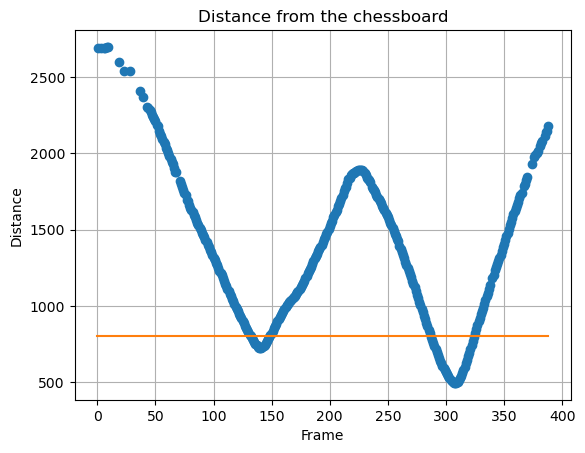

In [159]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Computing distances during the whole video by using dense disparity maps


## Crop a central area for all the frames

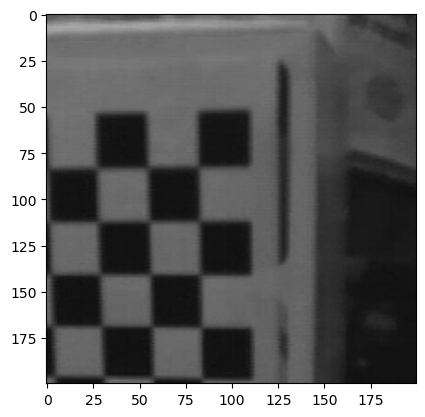

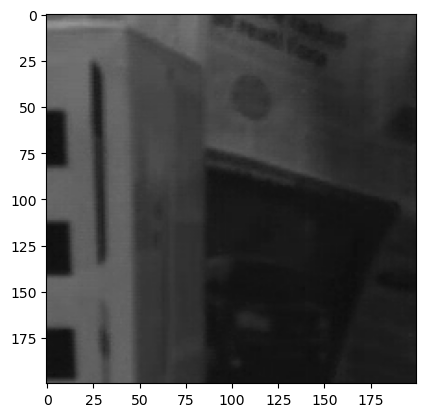

In [160]:
# Store the cropped images in 2 lists

list_L_cropped = []
list_R_cropped = []

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

for framenumber in range(number_of_frames):
    np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side-offset:int(Frame_width/2)+sq_area_side-offset]
    list_L_cropped.append(np_L_cropped)
    list_R_cropped.append(np_R_cropped)

plt.imshow(cv2.cvtColor(list_L_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(list_R_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()

## Calculate mean disparity for each frame by using StereoBM

In [161]:

list_mean_disparity = []
disparity_map_list = []

numDisparities=128;
block_size=21;

stereo = cv2.StereoBM_create(numDisparities, block_size)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
    
    
    mean_disparity = np.mean(disparity_px)

    
    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)


    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list.append(disparity)

Mean disparity (d_mean) for each frame:
0: 20.46
1: 20.46
2: 20.45
3: 20.44
4: 20.49
5: 20.43
6: 20.46
7: 20.42
8: 20.44
9: 20.46
10: 20.46
11: 20.46
12: 20.54
13: 20.55
14: 20.63
15: 20.77
16: 20.79
17: 20.84
18: 20.91
19: 20.99
20: 21.09
21: 21.18
22: 21.18
23: 21.2
24: 21.36
25: 21.5
26: 21.48
27: 21.46
28: 21.36
29: 21.44
30: 21.45
31: 21.51
32: 21.53
33: 21.48
34: 21.44
35: 21.35
36: 21.43
37: 21.45
38: 21.5
39: 21.72
40: 21.81
41: 22.05
42: 22.23
43: 22.56
44: 22.82
45: 22.94
46: 23.12
47: 23.39
48: 23.67
49: 23.88
50: 24.11
51: 24.22
52: 24.38
53: 24.63
54: 24.69
55: 24.83
56: 24.93
57: 25.06
58: 25.25
59: 25.4
60: 25.47
61: 25.71
62: 25.86
63: 26.03
64: 26.18
65: 26.33
66: 26.53
67: 26.7
68: 26.8
69: 27.06
70: 27.27
71: 27.5
72: 27.71
73: 28.06
74: 28.24
75: 28.45
76: 28.65
77: 28.82
78: 29.06
79: 29.26
80: 29.52
81: 29.64
82: 29.96
83: 30.16
84: 30.52
85: 30.87
86: 30.97
87: 31.55
88: 31.73
89: 31.92
90: 32.2
91: 32.4
92: 32.73
93: 32.96
94: 33.2
95: 33.57
96: 33.83
97: 34.08


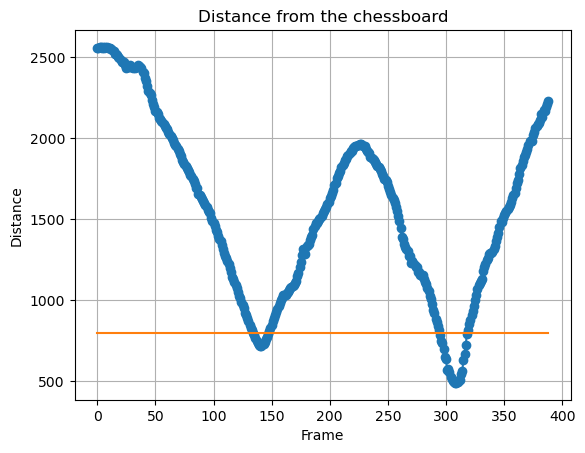

In [162]:
# distance calculation

list_z = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)
        

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## Calculate mean disparity for each frame by using StereoSGBM

In [163]:
list_mean_disparity = []
disparity_map_list = []

minDisparity=0                   # Minimum possible disparity value
numDisparities=128               # Range of disparity (maxDisparity - minDisparity)
block_size= 21                   # Size of the window used for matching (odd values only)
P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0                  # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0                # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,block_size,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)

print("Mean disparity (d_mean) for each frame:")
for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
    
    
    mean_disparity = np.mean(disparity_px)

    
    list_mean_disparity.append(mean_disparity)
    d_mean = np.mean(disparity_px)
    mean_disparity = round(d_mean, 2)


    print(f"{framenumber}: {mean_disparity}")
    
    disparity_map_list.append(disparity)

Mean disparity (d_mean) for each frame:
0: 20.58
1: 20.54
2: 20.5
3: 20.63
4: 20.63
5: 20.47
6: 20.72
7: 20.49
8: 20.51
9: 20.49
10: 20.57
11: 20.57
12: 20.37
13: 20.23
14: 20.3
15: 20.62
16: 20.67
17: 20.44
18: 20.69
19: 20.97
20: 21.33
21: 21.16
22: 21.16
23: 21.21
24: 21.11
25: 20.9
26: 21.12
27: 20.65
28: 20.63
29: 20.84
30: 20.98
31: 21.27
32: 21.25
33: 21.23
34: 21.52
35: 21.42
36: 21.45
37: 21.33
38: 21.34
39: 21.71
40: 21.9
41: 22.17
42: 22.21
43: 22.41
44: 22.59
45: 22.84
46: 22.98
47: 22.99
48: 23.37
49: 23.99
50: 24.37
51: 24.53
52: 24.73
53: 24.7
54: 24.86
55: 25.0
56: 25.06
57: 25.0
58: 25.21
59: 25.55
60: 25.54
61: 25.52
62: 25.5
63: 25.61
64: 26.07
65: 26.4
66: 26.64
67: 26.75
68: 26.88
69: 27.06
70: 27.36
71: 27.6
72: 27.6
73: 27.79
74: 27.97
75: 28.25
76: 28.53
77: 28.81
78: 28.92
79: 29.06
80: 29.17
81: 29.43
82: 29.89
83: 30.24
84: 30.47
85: 30.83
86: 30.8
87: 31.53
88: 31.82
89: 32.15
90: 32.38
91: 32.77
92: 33.12
93: 33.47
94: 33.84
95: 34.22
96: 34.25
97: 34.48
98

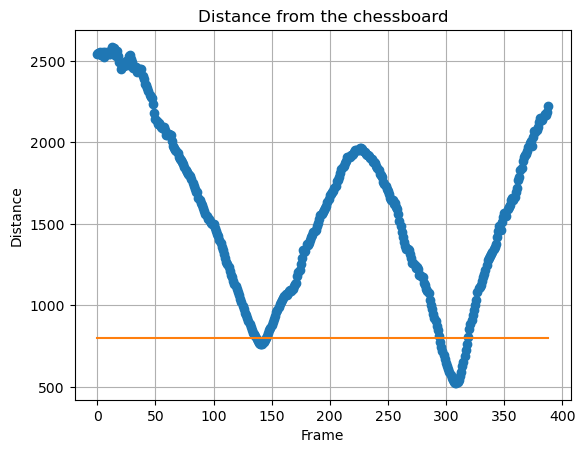

In [164]:
# distance calculation

list_z = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)
        

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## Calculate mean disparity for each frame by using custom disparity function

In [315]:
list_mean_disparity = []
disparity_map_list = []

d_max = 128
block_size = 21
cost_fn = ssd_fn # sad_fn, ssd_fn, ncc_fn, zncc_fn

print("Mean disparity (d_mean) for each frame:")
#@numba.njit
def calculate_disparity(framenumber, list_L_cropped, list_R_cropped, d_max, block_size, cost_fn):
    for framenumber in range(number_of_frames):
        disparity, cost = compute_disparity_map_parallel(list_L_cropped[framenumber],list_R_cropped[framenumber], d_max, block_size, cost_fn)

        positive_disparities = disparity[disparity >= 0]   
            
        d_mean = np.mean(positive_disparities)
        list_mean_disparity.append(d_mean)
        
        mean_disparity = round(d_mean, 2)
        print(f"{framenumber}: {mean_disparity}")
        
        disparity_map_list.append(disparity)
    return list_mean_disparity, disparity_map_list

list_mean_disparity, disparity_map_list = calculate_disparity(number_of_frames, list_L_cropped, list_R_cropped, d_max, block_size, cost_fn)

Mean disparity (d_mean) for each frame:
0: 20.48
1: 20.47
2: 20.48
3: 20.48
4: 20.51
5: 20.5
6: 20.52
7: 20.51
8: 20.49
9: 20.5
10: 20.53
11: 20.51
12: 20.56
13: 20.63
14: 20.78
15: 20.87
16: 20.95
17: 21.01
18: 21.12
19: 21.13
20: 21.18
21: 21.24
22: 21.2
23: 21.29
24: 21.4
25: 21.47
26: 21.51
27: 21.47
28: 21.44
29: 21.5
30: 21.58
31: 21.64
32: 21.62
33: 21.52
34: 21.55
35: 21.53
36: 21.57
37: 21.62
38: 21.66
39: 21.8
40: 21.98
41: 22.2
42: 22.39
43: 22.61
44: 22.92
45: 23.09
46: 23.25
47: 23.44
48: 23.69
49: 23.91
50: 24.17
51: 24.42
52: 24.55
53: 24.7
54: 24.76
55: 24.95
56: 25.15
57: 25.31
58: 25.43
59: 25.47
60: 25.68
61: 25.88
62: 26.0
63: 26.14
64: 26.35
65: 26.5
66: 26.64
67: 26.73
68: 26.93
69: 27.18
70: 27.32
71: 27.45
72: 27.63
73: 27.94
74: 28.06
75: 28.26
76: 28.56
77: 28.74
78: 29.0
79: 29.21
80: 29.47
81: 29.72
82: 29.98
83: 30.14
84: 30.47
85: 30.79
86: 31.0
87: 31.4
88: 31.62
89: 31.93
90: 32.16
91: 32.45
92: 32.87
93: 33.05
94: 33.4
95: 33.71
96: 34.09
97: 34.35
98: 

([20.483226495726495,
  20.473076923076924,
  20.477564102564102,
  20.484188034188033,
  20.513995726495725,
  20.501175213675214,
  20.51794871794872,
  20.510790598290598,
  20.494871794871795,
  20.499145299145297,
  20.531196581196582,
  20.51260683760684,
  20.56111111111111,
  20.633440170940172,
  20.77820512820513,
  20.87275641025641,
  20.945940170940172,
  21.01378205128205,
  21.116239316239316,
  21.13023504273504,
  21.178418803418804,
  21.237179487179485,
  21.200747863247862,
  21.29455128205128,
  21.395833333333332,
  21.473824786324787,
  21.510790598290598,
  21.469978632478632,
  21.442200854700854,
  21.499145299145297,
  21.575534188034187,
  21.638568376068378,
  21.61645299145299,
  21.516773504273505,
  21.545192307692307,
  21.529700854700856,
  21.574358974358976,
  21.61645299145299,
  21.657692307692308,
  21.796153846153846,
  21.984081196581197,
  22.19540598290598,
  22.386431623931625,
  22.61378205128205,
  22.92200854700855,
  23.092628205128204,
 

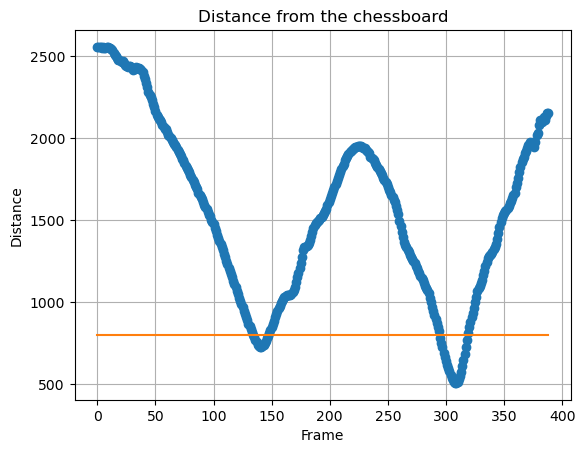

In [317]:
# distance calculation

list_z = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)
        

# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


In [314]:
print(list_mean_disparity[0:1]) 

[array([19, 19, 19, ..., 24, 24, 24])]


<h2> Trying to measure Chessboard W, H estimates </h2>

In [58]:
W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L
       
        w_px = w_px/8
        h_px = h_px/6
        W_mm = w_px*list_z[frame]/f     
        H_mm = h_px*list_z[frame]/f   
        w_px_list.append(w_px)
        h_px_list.append(h_px) 
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-175)
    else:
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)
    

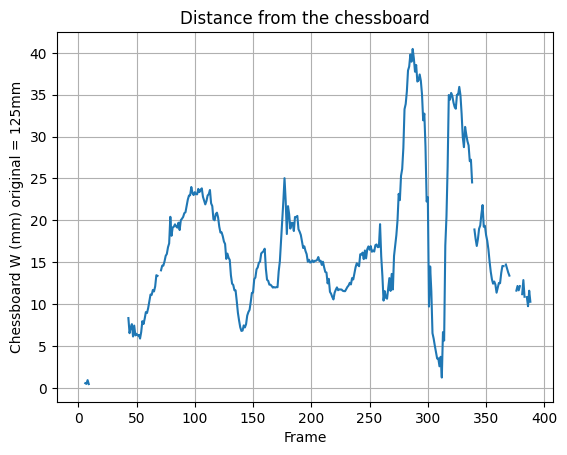

In [59]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Chessboard W (mm) original = 125mm')
plt.grid(True)
plt.show()

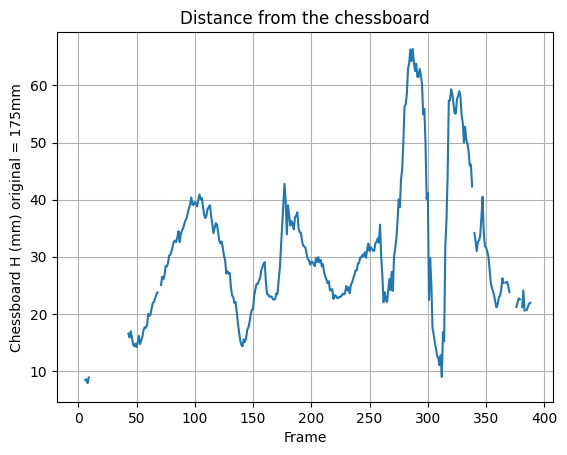

In [60]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, H_mm_diff)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Chessboard H (mm) original = 175mm')
plt.grid(True)
plt.show()

# video presentation

In [65]:
import cv2
import os

# Plotting
f_values = list(range(number_of_frames))
line = 800*np.ones((len(f_values)))

if not os.path.exists ('frames'):
    os.makedirs ('frames')

for framenumber in range(number_of_frames):
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title('Left Camera')
    axs[0, 0].imshow(list_L_cropped[framenumber], cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Right Camera')
    axs[0, 1].imshow(list_R_cropped[framenumber], cmap='gray')
    axs[0, 1].axis('off')
    axs[1, 0].set_title('Disparity Map')
    axs[1, 0].imshow(disparity_map_list[framenumber], cmap='jet')
    axs[1, 1].plot(f_values, list_z)
    axs[1, 1].plot(f_values, line)
    axs[1, 1].set_title('Distance: '+str(int(list_z[framenumber]))+' mm')
    axs[1, 1].plot(framenumber, list_z[framenumber], 'ro')
    
    if list_z[framenumber]<800:
        axs[1, 1].text(100, 2200, 'ALARM!!', fontsize=20, color='red')
    plt.savefig('frames/frame'+str(framenumber)+'.png')
    plt.close(fig)
    
    print(framenumber, end=', ')
  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [66]:
# Path to the frames folder
frames_folder = 'frames'

# Get the list of frame filenames
frame_filenames = os.listdir(frames_folder)

# Get the dimensions of the first frame
frame_path = os.path.join(frames_folder, frame_filenames[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

# Define the output video path
output_path = 'output_video.mp4'

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, 15, (width, height))

# Write each frame to the video
for filename in frame_filenames:
    frame_path = os.path.join(frames_folder, filename)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)
    
# Release the video writer
video_writer.release()

# Print the output path
print(f"Video saved to: {os.path.abspath(output_path)}")

Video saved to: c:\Users\Utente1\OneDrive\Desktop\img-proc\RobotNavigation-exp-fede\RobotNaviation2\RobotNavigation\output_video.mp4


# TODO
DONE :) 1. Understand why we get negative values to the cost function (and eventually fix it)
2. Find the distance from the custom disparity funciton as we did for the stereoSGBM. Compare the results with the 4 similarity/dissimilarity function.
3. Make the other code compatible with the custom funtion. 
4. see 3rd improvment
5. Do the report:
    1. define structure (what to say first and later)
    2. explain theory
    3. explain code
    4. show results
    5. improovments


#### USEFUL LINKS:
- https://github.com/IntelRealSense/librealsense/blob/master/doc/depth-from-stereo.md

- https://amroamroamro.github.io/mexopencv/matlab/cv.StereoSGBM.html

- https://learnopencv.com/depth-perception-using-stereo-camera-python-c/
